In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics import locations2degrees
from tqdm import tqdm

import catalog
import computations as cp
import figures

# catalog.display_parameters()

In [2]:
EQ = pd.read_csv("query.csv")
NONEQ = pd.read_csv("NONEQ.csv")

In [3]:
EQ = EQ[EQ["mag"] > 5.3]
print("Séisme ", len(EQ))

Séisme  1019


In [4]:
NONEQ = NONEQ[NONEQ["mag"] > 2.7]
print("Pas séisme ", len(NONEQ))

Pas séisme  1010


In [5]:
dataframe = pd.concat([EQ, NONEQ], ignore_index=True)

In [6]:
print("Taille catalogue ", len(dataframe))

Taille catalogue  2029


In [7]:
# Montrer tous les types

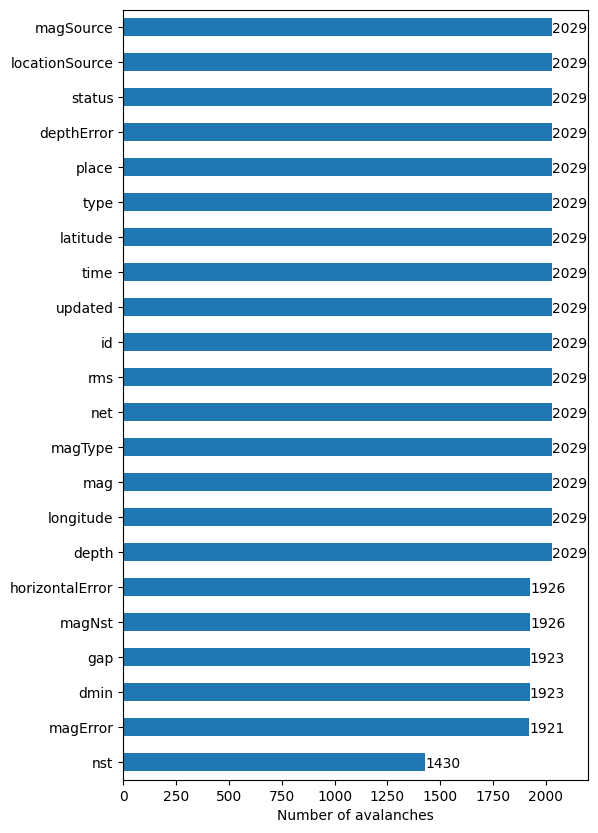

In [8]:
catalog.open_plot(dataframe, pos_number=0.15, xlim=2200)

In [9]:
dataframe["time"]

0       2024-11-01T17:19:14.776Z
1       2024-11-01T05:38:14.931Z
2       2024-10-30T20:15:19.955Z
3       2024-10-30T12:18:52.635Z
4       2024-10-25T14:46:22.315Z
                  ...           
2024    2020-01-13T23:04:30.948Z
2025    2020-01-11T13:00:56.700Z
2026    2020-01-09T20:20:49.175Z
2027    2020-01-09T18:16:48.436Z
2028    2020-01-06T20:39:10.290Z
Name: time, Length: 2029, dtype: object

In [10]:
start = dataframe["time"]

In [26]:
type(start)

pandas.core.series.Series

In [28]:
end = []
for i, y in enumerate(dataframe["time"]):
    end_unit = UTCDateTime(dataframe["time"][i]) + 300
    end.append(end_unit)

end = pd.Series(end)

In [29]:
type(end)

pandas.core.series.Series

In [ ]:
client = Client("IRIS")

def download_inventory(event, start, end, maxradius=1.0):
    ## Download station inventory from client
    return client.get_stations(
        latitude=event.latitude,
        longitude=event.longitude,
        startbefore=start,
        endafter=end,
        maxradius=maxradius,
        matchtimeseries=True,
        channel="BH*,HH*",
    )

In [ ]:
dataframe["inventory"] = dataframe.progress_apply( 
    lambda row: download_inventory(event, start, end, maxradius=1.0):, axis=1
)

dataframe.to_pickle("4_dataframe_88.pickle")

In [ ]:
# Convert the "time" column to numeric, assuming it's in a suitable string format
dataframe["time"] = pd.to_numeric(dataframe["time"], errors='coerce')

# Now, you can perform your arithmetic operation
start, end = dataframe["time"], dataframe["time"] + 300

In [ ]:
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics import locations2degrees
from tqdm import tqdm

## Connect to the FSDN server, or the IRIS datacenter. Because this variable is defined outside any function, it is visible by all functions of this module.
client = Client("IRIS")

def download_stream(event, time_margins=150, print_error=False, retries=3):
    """
    Download stream of waveforms for a given event.

    Parameters
    ----------
    event : pd.Series
        A series containing the event information.
    time_margins : float
        The number of seconds to add to the start and end times of the event.
    print_error : bool
        Whether to print error messages.
    retries : int
        Number of times to retry the request in case of an error.

    Returns
    -------
    stream : obspy.Stream
        A stream of waveforms for the event.
    """

    ## Start time and end time of the event
    # Convert the "time" column to numeric, assuming it's in a suitable string format
    dataframe["time"] = pd.to_numeric(dataframe["time"], errors='coerce')

    # Now, you can perform your arithmetic operation
    start, end = dataframe["time"], dataframe["time"] + 300
    start, end = start - time_margins, end + time_margins

    ## The stream for adding traces
    stream = Stream()

    ## Download and add traces in stream
    for network in tqdm(event.inventory):
        if any(char.isdigit() for char in network.code):
            continue

        for station in network:
            for attempt in range(retries):
                try:
                    traces = client.get_waveforms(
                        network.code,
                        station.code,
                        "*",
                        "BH*,HH*",
                        start,
                        end,
                        attach_response=True,
                    )

                    traces.merge(method=1, fill_value="interpolate")

                    distance = locations2degrees(
                        event.latitude,
                        event.longitude,
                        station.latitude,
                        station.longitude,
                    )

                    for trace in traces:
                        trace.stats.distance = distance * 111.19

                    stream += traces
                    break  ## Break the retry loop if successful
                
                ## If an error occurs, the code restarts
                except Exception as e:
                    if print_error:
                        print(f"Error with station {station}. Attempt {attempt + 1} of {retries}. Error: {e}")
                    continue  ## Retry

    return stream

In [ ]:
for event in tqdm(dataframe.itertuples(), total=len(dataframe)):
    #if event.Index == 0 : ## Uncomment this line to download a specific event
        stream = download_stream(event, time_margins=0, print_error=True)
        if stream:
            stream.write(f"sismogrammes/{event.Index:03d}.pickle", format="PICKLE")

In [ ]:
fd = catalog.load("catalog/10_features_dataframe.pickle")

catalog.open_plot(fd, pos_number=0.15, xlim=35)

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Charger et préparer les données (X = caractéristiques, y = étiquettes)
X = fd
y = ESEC_avalanches["category"]

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Créer un encodeur de labels
label_encoder = LabelEncoder()

# Encoder les catégories
y_encoded = label_encoder.fit_transform(y)

# Afficher les étiquettes encodées
print("Étiquettes encodées :", y_encoded)
print("Classes correspondantes :", label_encoder.classes_)

import pandas as pd

# Exemple pour encodage des colonnes catégorielles
X = pd.get_dummies(X)

In [ ]:
# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Créer et entraîner le modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
# Évaluer les performances
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
y_pred

In [ ]:
X_test